In [2]:
import src.net as net
import sklearn.metrics
import torch.nn as nn
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import importlib
import src.params as params
import src.main as main
import src.dataloader as dataloader
import torch.nn.functional as F
import pandas as pd
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
import src.preprocess as preprocess
from copy import copy
import src.feature_extraction as feature_extraction
import sys, os, torch
import re
importlib.reload(dataloader)
importlib.reload(preprocess)
importlib.reload(feature_extraction)
importlib.reload(net)

<module 'src.net' from '/home/junetheriver/code/aiops/src/net.py'>

In [3]:
args = params.get_args("../config/system_a.yaml")

In [4]:
cause_id = {"网络丢包": 0,
             "网络延迟": 1,
             "JVM CPU负载高": 2,
             "CPU使用率高": 3,
             "磁盘空间使用率过高": 4,
             "内存使用率过高": 5,
             "JVM OOM Heap": 6,
             "磁盘IO读使用率过高": 7}
cause_literal = list(cause_id.keys())

In [5]:
from itertools import islice
import openpyxl

# 对root cause进行统计
gt_path = "../../data/groundtruth_a.xlsx"
wb = openpyxl.load_workbook(gt_path)
ws = wb.active
data = ws.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df = DataFrame(data, index=idx, columns=cols)
df["故障内容"] = df["故障内容"].map(lambda x: cause_id[x])
df['time'] = pd.to_datetime(df.time)
df['time'] = df['time'] - pd.Timedelta('08:00:00')
root_cause = {i:set() for i in range(8)}
rt_list = list(zip(df.根因, df.故障内容))
for rt, label in rt_list:
    for key_metric in rt.split(';\n'):
        root_cause[label].add(key_metric)
for key, item in root_cause.items():
    print(cause_literal[key], item)

网络丢包 {'icmp', 'net', 'tcp', 'udp', 'ping'}
网络延迟 {'icmp', 'net', 'tcp', 'udp', 'ping'}
JVM CPU负载高 {'cpu', 'system.load', 'weblogic'}
CPU使用率高 {'cpu', 'system.load'}
磁盘空间使用率过高 {'disk'}
内存使用率过高 {'mem'}
JVM OOM Heap {'mem', 'weblogic'}
磁盘IO读使用率过高 {'system.io'}


In [6]:
from src.feature_extraction import get_cmdb_idx
from src.dataloader import get_cmdb, load_dt_raw

data, cmdb_kpi = get_cmdb(args)
cmdb_idx_dt = get_cmdb_idx(cmdb_kpi, len(cmdb_kpi))
cmdb_list = list(set([ck[0] for ck in cmdb_kpi]))
kpi_list = list(set([ck[1] for ck in cmdb_kpi]))
print(f"clen {len(cmdb_list)}, klen {len(kpi_list)}")

Loading preprocessed data from /home/junetheriver/code/aiops/workdir/system_a/data_pre.pkl
clen 35, klen 121


In [9]:
from src.net import get_kpi_at_time

In [32]:
cmdb = "gjjcore8"
df_cmdb = df[df.cmdb_id == cmdb]
metric_dir = "../../data/system-a"
fig_save_dir = "../../temp/kpi_analysis/2/"
start_time = 1614268800

for key, item in root_cause.items():
    anomaly_type = cause_literal[key]
    print(anomaly_type)
    occur_time = df_cmdb[df_cmdb["故障内容"] == key].iloc[0].time.timestamp()

    plt.figure(figsize=(16,8))
    legends = []
    stds = []
    for cause in item:
        for filename in os.listdir(metric_dir):
            if cause in filename and cmdb in filename:
                kpi = '.'.join(filename.split('##')[1].split('.')[:-1])
                try:
                    idx = cmdb_kpi.index((cmdb, kpi))
                except ValueError:
                    continue
                ts = get_kpi_at_time(data, idx, int((occur_time - start_time)/60)-10, 20)
                if ts.std() < 1e-2:
                    continue
                stds.append(ts.std())
                plt.plot(ts)
                legends.append(kpi)
    plt.legend(legends)
    plt.savefig(os.path.join(fig_save_dir, f"{anomaly_type}.jpg"))
    # plt.show()
    plt.close()

网络丢包
网络延迟
JVM CPU负载高
CPU使用率高
磁盘空间使用率过高
内存使用率过高
JVM OOM Heap
磁盘IO读使用率过高


In [34]:
data

array([[-0.04553757,  1.58086478, -1.65105347, ..., -0.12286924,
         0.39053664,  0.29803004],
       [-0.04553757,  1.58086478, -1.65097055, ..., -0.12286924,
         0.38576372, -0.74699019],
       [-0.04553757,  1.58086478, -1.65088745, ..., -0.12286924,
         0.38815018, -0.74699019],
       ...,
       [-0.04553757, -0.63256517,  1.56607529, ..., -0.12286924,
        -0.20369221,  2.38807049],
       [-0.04553757, -0.63256517,  1.56615873, ..., -0.12286924,
        -0.20369221,  1.34305026],
       [-0.04553757, -0.63256517,  1.5662401 , ..., -0.12286924,
        -0.20369221,  1.34305026]])

In [8]:
import numpy as np
print(data.shape)
data_filled = np.nan_to_num(data)
co = np.corrcoef(data_filled, rowvar=False)

(38880, 2152)


In [20]:
co.shape

(2152, 2152)

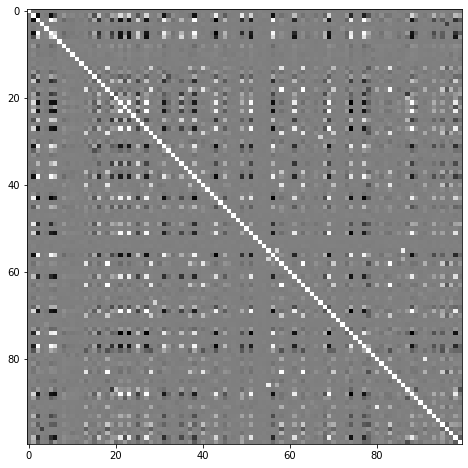

In [26]:
plt.figure(figsize=(8,8))
plt.imshow(co[:100,:100], cmap='gray')

In [13]:
importlib.reload(net)
data_pad = np.pad(data_filled, [(0,0), (0,1)])
print(len(kpi_list))
uniset_glob = {kpi:set() for kpi in kpi_list}
for cmdb in cmdb_list:
    cmdb_data = net.get_cmdb_all(data_pad, cmdb_idx_dt[cmdb])
    cmdb_data = np.nan_to_num(cmdb_data)
    co = np.corrcoef(cmdb_data, rowvar=False)
    co = np.abs(np.nan_to_num(co))

    uniset = {kpi:kpi for kpi in kpi_list}

    for ki, kpi in enumerate(kpi_list):
        for kj in range(ki+1, len(kpi_list)):
            if co[ki][kj] > 0.9:
                uniset[kpi_list[kj]] = uniset[kpi]

    for kpi in kpi_list:
        uniset_glob[kpi].add(uniset[kpi])
    plt.figure(figsize=(8,8))
    plt.imshow(co, cmap='gray')
    plt.title(cmdb)
    plt.savefig("../../temp/corr/" + f"{cmdb}.jpg")
    plt.close()

121


/home/junetheriver/code/ml/bayes/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/junetheriver/code/ml/bayes/venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [94]:
cluster = []
for kpi in kpi_list:
    c = uniset_glob[kpi]
    if c in cluster:
        continue
    done = False
    for cc in cluster:
        if c.intersection(cc):
            cluster.remove(cc)
            cluster.append(c.union(cc))
            done = True
            break
    if not done:
        cluster.append(c)
for c in cluster:
    print(c)

{'object.alert'}
{'oracle.patchrate.fsfi'}
{'redis.replication.backlog_histlen'}
{'oracle.tablespace.used.percentage'}
{'haproxy.backend.connect.time'}
{'oracle.lock.wait.second'}
{'oracle.asm.disk.group.free', 'oracle.asm.disk.group.usage_pct'}
{'redis.mem.used'}
{'system.net.udp.no_ports'}
{'weblogic.webapp.current.sessions'}
{'oracle.process.freeable.pct_usage'}
{'haproxy.backend_up'}
{'oracle.can_connect'}
{'weblogic.basic.heap.size'}
{'oracle.sga.sharepool'}
{'system.tcp.fin_wait2'}
{'weblogic.can_connect'}
{'system.mem.shared'}
{'redis.net.clients', 'redis.clients.blocked'}
{'weblogic.jdbc.active_conn_avg'}
{'oracle.ratio.dictionarycacheratio'}
{'oracle.process.total.pga.inuse', 'oracle.ratio.cacheratio', 'oracle.pga.maximum.pga.allocated', 'oracle.redo.willing.gets', 'oracle.process.total.pga.allocated', 'oracle.process.useable.total', 'oracle.pga.cache.hit.percentage', 'oracle.redo.willing.misses'}
{'weblogic.basic.active.sockets.connections'}
{'haproxy.frontend.errors.req_rate

In [108]:
from sklearn.cluster import KMeans, k_means, MiniBatchKMeans
for cmdb in cmdb_list:
    cmdb_data = net.get_cmdb_all(data_pad, cmdb_idx_dt[cmdb])
    kmeans = MiniBatchKMeans(n_clusters=10)
    cluster_result = kmeans.fit_predict(cmdb_data.transpose())
    print(cluster_result)

[6 2 2 2 2 2 2 5 2 2 8 7 6 2 2 9 7 2 2 9 7 1 2 2 7 6 7 0 4 2 2 5 2 5 2 2 2
 1 2 7 4 2 2 1 1 2 4 2 5 6 2 2 2 2 2 2 3 6 6 4 2 2 1 2 8 8 3 2 9 2 8 2 2 2
 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 8 0 5 2 2 2 5 2 2 2 2 2 8 2 8 4 2 1 6
 4 3 2 2 2 1 4 2 2 2]
[3 1 1 1 1 4 1 4 1 1 8 0 5 1 1 3 0 1 1 3 0 4 1 1 0 5 2 1 6 2 1 4 1 4 1 1 7
 2 1 1 1 1 1 2 2 7 6 1 2 3 1 1 1 1 1 1 0 3 3 6 1 1 2 1 8 8 0 1 3 1 9 5 1 1
 3 1 4 1 1 1 1 1 1 1 1 7 1 1 1 1 2 1 1 1 2 1 1 1 4 1 1 1 1 1 2 1 9 6 5 2 5
 6 0 1 1 1 2 6 1 1 1]
[2 1 1 1 1 1 1 1 1 1 6 7 8 1 1 2 7 1 1 2 7 1 1 1 7 1 1 4 5 3 1 3 1 1 1 1 1
 3 1 1 1 1 1 3 0 1 5 1 3 2 1 1 1 1 1 1 9 2 2 5 1 1 1 1 3 6 9 1 2 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 0 1 1 4 3 1 1 1 1 1 1 1 1 1 6 1 1 5 8 0 8
 5 9 1 1 1 1 5 1 1 1]
[6 6 6 6 9 6 1 6 1 6 6 6 6 6 6 6 6 1 1 6 6 6 6 5 6 6 6 6 6 6 6 6 6 6 6 0 6
 6 6 6 6 1 6 6 6 6 6 0 6 6 6 6 0 6 6 6 6 6 6 6 1 1 6 1 6 6 6 6 6 6 6 6 2 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 1 6 1 6 6 6 6 0 6 6 6 6 6 6 6 6 3 6 6 6 6 6
 6 6 4 6 6 6 6 6 6 6]
[5 3 3 3 3 3

array([[ 0.35504683, -0.47829372, -0.47829372, ...,  4.52174958,
        -0.47829372,  1.18838738],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00995333, -0.00995333, -0.00995333, ..., -0.00995333,
        -0.00995333, -0.00995333],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [2]:
import numpy as np
a = np.array([[0,0,0,0], [np.nan, np.nan, np.nan, np.nan]]).transpose()
np.isnan(a[:,[0,1]]).all()

False

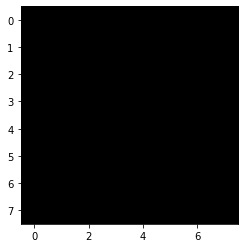

In [10]:
black = np.zeros((8,8))
plt.imshow(black,cmap='gray')